In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)



In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd


train_data = pd.read_table('/content/drive/MyDrive/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [ ]:
x_val = X_train[:20000]
y_val = y_train[:20000]

partial_x_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [ ]:
vocab_size = len(index_to_word)
word_vector_dim = 300

In [ ]:
#RNN Model
 
rnn_model = tf.keras.Sequential(name='RNN')
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(8))   
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

rnn_model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 9888      
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 1-D CNN Model

cnn_model = tf.keras.Sequential(name='CNN')
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         3000000   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          33616     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                 136     

In [ ]:
# GlobalMaxPooling1D Model

gmp_model = tf.keras.Sequential(name='GMP')
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

gmp_model.summary()

Model: "GMP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         3000000   
                                                                 
 global_max_pooling1d_4 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 8)                 2408      
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
models = [rnn_model.name,cnn_model.name,gmp_model.name]

In [ ]:
model_results = {}
history_dict = {}
for model_name in models :
  if model_name == 'RNN' : model = rnn_model
  elif model_name == 'CNN' : model = cnn_model
  else : model = gmp_model


  model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

  epochs = 10
  print('-'*10 + model_name +'-'*10)
  history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(x_val,y_val),verbose=1)
  print('-'*10 + model_name + 'results'+'-'*10)  
  results = model.evaluate(X_test,y_test,verbose=2)
  model_results[model_name] = results
  history_dict[model_name] = history.history

----------RNN----------
Epoch 1/10
247/247 [==============================] - 38s 147ms/step - loss: 0.4416 - accuracy: 0.8103 - val_loss: 0.3522 - val_accuracy: 0.8489
Epoch 2/10
247/247 [==============================] - 36s 146ms/step - loss: 0.3183 - accuracy: 0.8676 - val_loss: 0.3345 - val_accuracy: 0.8582
Epoch 3/10
247/247 [==============================] - 36s 146ms/step - loss: 0.2838 - accuracy: 0.8820 - val_loss: 0.3359 - val_accuracy: 0.8569
Epoch 4/10
247/247 [==============================] - 36s 145ms/step - loss: 0.2560 - accuracy: 0.8949 - val_loss: 0.3415 - val_accuracy: 0.8547
Epoch 5/10
247/247 [==============================] - 36s 144ms/step - loss: 0.2291 - accuracy: 0.9071 - val_loss: 0.3635 - val_accuracy: 0.8531
Epoch 6/10
247/247 [==============================] - 36s 144ms/step - loss: 0.2058 - accuracy: 0.9181 - val_loss: 0.3902 - val_accuracy: 0.8520
Epoch 7/10
247/247 [==============================] - 36s 145ms/step - loss: 0.1847 - accuracy: 0.9283 - v

In [ ]:
model_results

{'CNN': [0.8812132477760315, 0.8334723711013794],
 'GMP': [0.5935193300247192, 0.8420571088790894],
 'RNN': [0.4932630956172943, 0.8383546471595764]}

In [ ]:
history_dict

{'CNN': {'accuracy': [0.8026739358901978,
   0.8763611316680908,
   0.9089965224266052,
   0.9431139230728149,
   0.9658271670341492,
   0.9780238270759583,
   0.9848155975341797,
   0.988627552986145,
   0.9902521967887878,
   0.990608811378479],
  'loss': [0.4251386821269989,
   0.29480114579200745,
   0.23048241436481476,
   0.15856009721755981,
   0.10080383718013763,
   0.06752384454011917,
   0.047637566924095154,
   0.036501046270132065,
   0.03028235398232937,
   0.028254594653844833],
  'val_accuracy': [0.8522499799728394,
   0.8547999858856201,
   0.8551499843597412,
   0.850350022315979,
   0.8481500148773193,
   0.8396999835968018,
   0.8396499752998352,
   0.8429999947547913,
   0.8356500267982483,
   0.8377000093460083],
  'val_loss': [0.3401622474193573,
   0.33391842246055603,
   0.34800514578819275,
   0.40084555745124817,
   0.47815272212028503,
   0.5744741559028625,
   0.6299048662185669,
   0.7186070084571838,
   0.762489914894104,
   0.8560263514518738]},
 'GMP': 

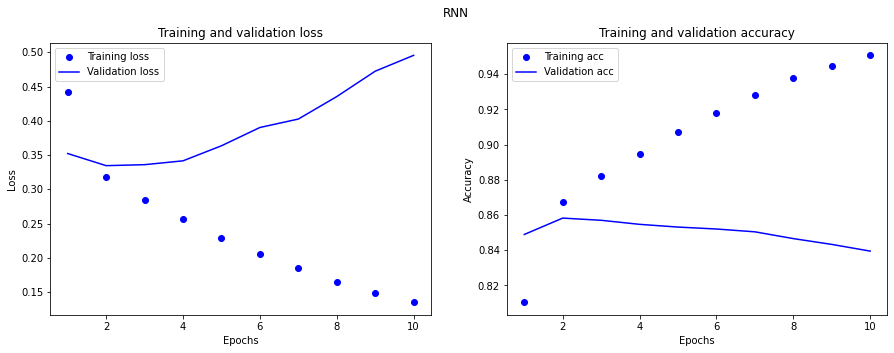

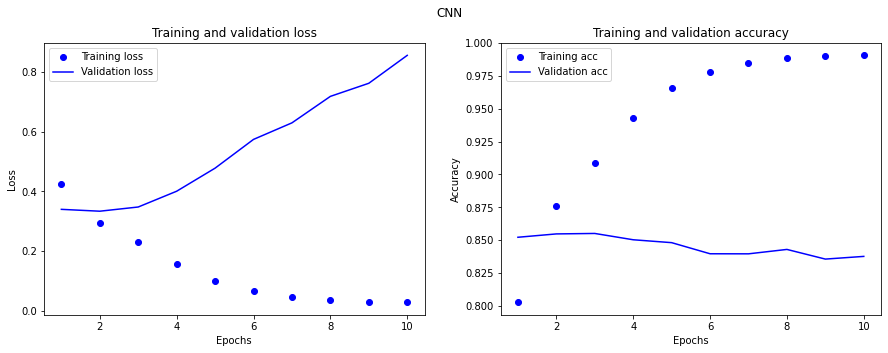

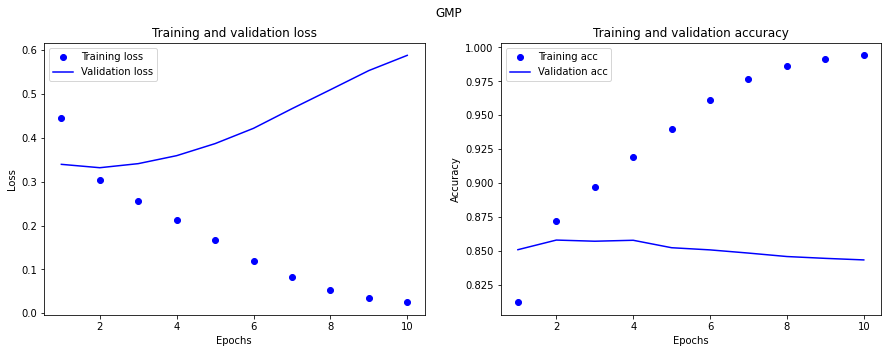

In [ ]:
import matplotlib.pyplot as plt

keys = list(history_dict.keys())


for i in range(3):
  fig = plt.figure(i,figsize=(15,5))
  fig.suptitle(keys[i])

  acc = history_dict[keys[i]]['accuracy']
  val_acc = history_dict[keys[i]]['val_accuracy']
  loss = history_dict[keys[i]]['loss']
  val_loss = history_dict[keys[i]]['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,'bo',label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()



In [ ]:
word2vec_file_path = '/content/drive/MyDrive/data/ko_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-5.12406183e-03, -2.57721934e-02, -3.38492841e-02,  3.41253318e-02,
       -1.48703018e-02, -4.53643799e-02, -3.20647918e-02, -2.01675296e-02,
       -4.58781347e-02, -2.09752545e-02, -1.06266756e-02, -1.10572577e-03,
       -4.00162488e-03,  1.27841523e-02,  7.09359720e-02,  2.47805361e-02,
       -4.51766737e-02,  1.74558759e-02, -1.48855383e-02, -5.60782738e-02,
       -4.42843698e-02, -3.70503627e-02, -3.81508358e-02, -4.14298996e-02,
        3.07783224e-02, -1.58607047e-02,  1.22492872e-02, -3.27719264e-02,
       -1.33386739e-02, -1.75211076e-02, -9.68274754e-03, -4.96355779e-02,
        2.34979414e-03, -4.84100357e-02,  6.37887919e-04, -3.78799438e-02,
       -2.32180059e-02, -2.34500449e-02, -3.42796035e-02,  2.32565496e-02,
        1.45670837e-02,  9.65988636e-03, -1.22531010e-02, -6.07633032e-02,
       -4.93360758e-02, -1.93660539e-02, -3.81469950e-02,  8.71146284e-03,
       -1.16166817e-02, -2.88563017e-02, -3.73712257e-02, -4.02758010e-02,
       -2.90309899e-02, -

In [ ]:
word_vectors.similar_by_word('love')

[('잼따', 0.6045466661453247),
 ('홧팅', 0.5965070724487305),
 ('乃', 0.5867186784744263),
 ('천사', 0.5833028554916382),
 ('조음', 0.5817431211471558),
 ('아름다워요', 0.5797837376594543),
 ('am', 0.570914626121521),
 ('♥♥', 0.5684590339660645),
 ('고마워요', 0.563900351524353),
 ('넘침', 0.5630855560302734)]

In [ ]:
from gensim.models import Word2Vec

word2vec_path = '/content/drive/MyDrive/data/ko.bin'

word2vec = Word2Vec.load(word2vec_path)

In [ ]:
word2vec.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_3 (LSTM)               (None, 256)               467968    
                                                                 
 dense_16 (Dense)            (None, 8)                 2056      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [78]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 322s 1s/step - loss: 0.4759 - accuracy: 0.7703 - val_loss: 0.4000 - val_accuracy: 0.8167
Epoch 2/10
247/247 [==============================] - 318s 1s/step - loss: 0.3537 - accuracy: 0.8453 - val_loss: 0.3600 - val_accuracy: 0.8398
Epoch 3/10
247/247 [==============================] - 316s 1s/step - loss: 0.3086 - accuracy: 0.8683 - val_loss: 0.3242 - val_accuracy: 0.8590
Epoch 4/10
247/247 [==============================] - 314s 1s/step - loss: 0.2765 - accuracy: 0.8849 - val_loss: 0.3198 - val_accuracy: 0.8654
Epoch 5/10
247/247 [==============================] - 314s 1s/step - loss: 0.2541 - accuracy: 0.8949 - val_loss: 0.3235 - val_accuracy: 0.8627
Epoch 6/10
247/247 [==============================] - 315s 1s/step - loss: 0.2308 - accuracy: 0.9065 - val_loss: 0.3284 - val_accuracy: 0.8623
Epoch 7/10
247/247 [==============================] - 316s 1s/step - loss: 0.2078 - accuracy: 0.9170 - val_loss: 0.3338 - val_accuracy: 0.8634

In [80]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 80s - loss: 0.4009 - accuracy: 0.8567 - 80s/epoch - 52ms/step
[0.4008544981479645, 0.85670405626297]
